<center>
    <h1><b><font color="blue"> Notebook 3.2 - Choix de l'agorithme</font> </b></h1>
</center>

<b>Objectif du Notebook :</b>
<p>Tester les différents algorithmes que nous avons à notre disposition pour tester la prédiction de la pluie du lendemain </p>

<b> Liste des algorithmes testés : </b>
<i><ul>
- Arbre de décision
- Boosting sur arbre de décision
- Régression logistique
- SVM
- KNN
- Random Forest
- Light GBM
- Bagging Classifier
- Stacking    
</ul></i>

<b> Optimisation des modèles : </b>
<i><ul>
- Une grille de recherche sur les hyperparamètres a été construite pour les modèles avec le choix de maximiser le f1 comme métrique de performance et 3 folds pour limiter le surapprentissage
</ul></i>

<b> Choix du modèle : </b>
<i><ul>
- Le modèle finale sera choisi au regard de la courbe de ROC, de l'AUC globale et surtout des métriques f1_score, precision, rappel sur la classe à modéliser
</ul></i>

<b> Définitions : </b>

La precision correspond au taux de prédictions correctes parmi les prédictions positives. Elle mesure la capacité du modèle à ne pas faire d’erreur lors d’une prédiction positive.
<br>
Le recall correspond au taux d’individus positifs détectés par le modèle. Il mesure la capacité du modèle à détecter l’ensemble des individus positifs.
<br>
Le F1-score évalue la capacité d’un modèle de classification à prédire efficacement les individus positifs, en faisant un compromis entre la precision et le recall.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from  scipy.spatial.distance import cdist

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons, make_blobs
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV

from sklearn.metrics import make_scorer, classification_report, recall_score, f1_score, precision_recall_fscore_support, precision_recall_curve, roc_curve,auc, precision_score, roc_auc_score

from scipy.cluster.hierarchy import dendrogram,linkage

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, KFold
from imblearn.under_sampling import RandomUnderSampler

from sklearn.tree import DecisionTreeClassifier

import lightgbm as lgb

import xgboost as xgb

import shap, lime

from joblib import dump, load
import pickle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # Autorise l'affichage de plusieurs sorties à partir d'une
                                                # même cellule (sans utiliser print)


C:\Users\A021128\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Import des fichiers de travail

**Chargements des jeux de données :**
 - df : données météo en australie sur 10 ans avec les NA retraités 

In [14]:
df = pd.read_csv(r"D:\dt\DTSPT\Formations\DataScientest\Projet_Meteo\bases\Final\weatherAUS_nan.csv")

In [15]:
df = df.dropna()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56564 entries, 9273 to 145431
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          56564 non-null  int64  
 1   Date                56564 non-null  object 
 2   Location            56564 non-null  object 
 3   MinTemp             56564 non-null  float64
 4   MaxTemp             56564 non-null  float64
 5   Rainfall            56564 non-null  float64
 6   Evaporation         56564 non-null  float64
 7   Sunshine            56564 non-null  float64
 8   WindGustSpeed       56564 non-null  float64
 9   WindSpeed9am        56564 non-null  float64
 10  WindSpeed3pm        56564 non-null  float64
 11  Humidity9am         56564 non-null  float64
 12  Humidity3pm         56564 non-null  float64
 13  Pressure9am         56564 non-null  float64
 14  Pressure3pm         56564 non-null  float64
 15  Cloud9am            56564 non-null  float64
 16  

# Decouverte du dataframe - Préprocessing

# Préparation des bases d'entrainement et de validation

In [17]:
clim_type_det = {'Am':'mousson',
                'Aw':'savane',
                'Cfa':'Subtropical humide',
                'Cfb':'Océanique/été tempéré', 
                'Cfc':'Océanique/été court et frais', 
                'BSh':'Semi-aride/sec et chaud',
                'BSk':'Semi-aride/sec et froid',
                'Bsk':'Semi-aride/sec et froid', 
                'Bwh':'Désertique/sec et chaud',
                'Csa':'Méditerranéen/été chaud',
                'Csb':'Méditerranéen/été tempéré'              
               }

df['Clim_type_det']=df['Climat_Koppen'].map(clim_type_det)

#df.Clim_type_det = LabelEncoder().fit_transform(df.Clim_type_det)


In [18]:
#Conversion des variables catégorielles en numérique

from category_encoders import OrdinalEncoder

#categorical_features = [col for col in X_df.columns if X_df[col].dtype == 'object']
categorical_features = ['Clim_type_det']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(df)

df=encoder.transform(df)

is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.


In [19]:
df= df.sort_values(["Location","Date"])
df["Rain_J+7"] = df["RainToday_Num"].shift(-7)

In [20]:
clim_indic_det = pd.get_dummies(df.Clim_type_det, prefix='Clim_Det')
df = df.join(clim_indic_det)

In [21]:
features = ["RainToday_Num","Rain_J-1","Rain_J-2","MinTemp","MaxTemp","Sunshine","Evaporation",
            "Humidity3pm","Humidity9am","Pressure9am","Pressure3pm","Cloud3pm","Cloud9am", 
            "Wind9am_cos","Wind3pm_cos","WindGust_cos","Wind9am_sin","Wind3pm_sin","WindGust_sin", 
            "Mois","Clim_type_det"]
data = df[features]

target = df["RainTomorrow_Num"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)

<hr>
<h1>Modélisation de la pluie à J+1</h1>
<hr>

<hr>
<h1>Rééchantillonage des données pour corriger le déséquilibre des deux classes</h1>
<h2>Sous-échantillonnage de la classe 0 - RandomUnderSampler</h2>
<hr>

In [23]:
rus = RandomUnderSampler() 
X_ru, y_ru = rus.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_ru_sc = scaler.fit_transform(X_ru)
X_test_sc = scaler.transform(X_test)

In [24]:
print("taille du jeu de données :", len(X_ru))

taille du jeu de données : 19854


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:title={'center':'Répartition de la cible'}, xlabel='RainTomorrow_Num', ylabel='count'>

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:title={'center':'Répartition de la cible après réchantillonage'}, xlabel='RainTomorrow_Num', ylabel='count'>

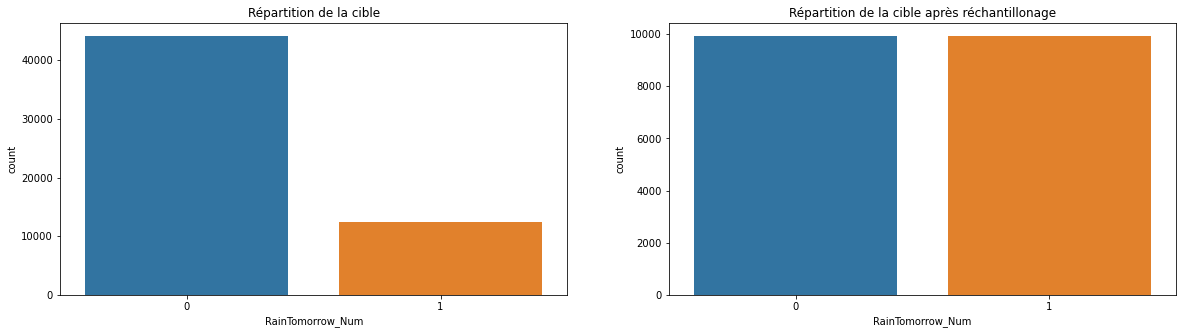

In [25]:
f = plt.figure( figsize= (20, 5) )
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.title.set_text('Répartition de la cible')
sns.countplot(target,ax=ax1)

ax2.title.set_text('Répartition de la cible après réchantillonage')
sns.countplot(y_ru,ax=ax2)


In [26]:
metric = make_scorer(f1_score,pos_label=1)
nfolds = 3

<hr>
<h1>Régression logistique</h1>
<hr>

In [ ]:
%%time

# création du dictionnaire des paramètres à tester
params = {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
           'C' : [100, 10, 1.0, 0.1, 0.01]
           }

# entrainement du modèle
lr_ru = LogisticRegression(max_iter=1000)
lr_ru_grid = GridSearchCV(estimator=lr_ru, param_grid=params,scoring=metric)

grille_lr_ru = lr_ru_grid.fit(X_ru_sc, y_ru)

print("Hyperparamètres retenus par le modèle :")
lr_ru_grid.best_params_

In [ ]:
%%time
#Modèle optimal Régression logistique
LogRef_ru = LogisticRegression(C=0.01, solver='newton-cg')
LogRef_ru.fit(X_ru_sc, y_ru)

In [ ]:
#Sauvegarde du modèle 
dump(LogRef_ru, "LogRef_ru.joblib")

<hr>
<h1>Arbre de décision</h1>
<hr>

In [ ]:
%%time

#Grille de recherche pour avoir les meilleurs hyperparametres pour le criterion et max_depth.
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15),'min_samples_split':[300],'min_samples_leaf':[100]}


# decision tree model
dtree_model=DecisionTreeClassifier()
# use gridsearch to test all values
dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds, scoring=metric)
#fit model to data
dtree_gscv.fit(X_ru, y_ru)

print("Hyperparamètres retenus :")
dtree_gscv.best_params_

In [27]:
%%time

#Création de l'arbre avec les meilleurs hyperparametres calculés ci-dessus

dt_clf_ru = DecisionTreeClassifier(criterion='gini', 
                                 max_depth=6,
                                 random_state=123,
                                 min_samples_leaf=100,
                                 min_samples_split=300)
dt_clf_ru.fit(X_ru , y_ru)

Wall time: 75.7 ms


DecisionTreeClassifier(max_depth=6, min_samples_leaf=100, min_samples_split=300,
                       random_state=123)

In [ ]:
#Sauvegarde du modèle 
dump(dt_clf_ru, "dt_clf_ru.joblib")

In [28]:
pickle_out1 = open("dt.pkl","wb")
pickle.dump(dt_clf_ru, pickle_out1)
pickle_out1.close()

<hr>
<h1>AdaBoost Classifier</h1>
<h2>Boosting à partir de l'arbre de décision ci dessus</h2>
<hr>

In [ ]:
%%time

ac_ru = AdaBoostClassifier(base_estimator=dt_clf_ru)

param_ada = {
    #'base_estimator__max_depth':[i for i in range(2,11,2)],
    #'base_estimator__min_samples_leaf':[5,10],
    #'n_estimators':[10,50,250,1000],
    #'learning_rate':[0.01,0.1]
}

ada_gscv_J1 = GridSearchCV(ac_ru, param_ada,cv=nfolds, scoring=metric,n_jobs=-1)
ada_gscv_J1.fit(X_ru,y_ru)
print(ada_gscv_J1.best_params_)

In [ ]:
%%time

ac_ru = AdaBoostClassifier(base_estimator=dt_clf_ru)
ac_ru.fit(X_ru,y_ru)

In [ ]:
#Sauvegarde du modèle 
dump(ac_ru, "ac_ru.joblib")

<hr>
<h1>Random Forest</h1>
<hr>

In [ ]:
# création du dictionnaire des paramètres à tester et instanciation du modèle RandomForest
params_rf = {'bootstrap' : [True, False],
          'max_depth' : [10, 25, 50, 75, 100],
          'max_features' : ['auto', 'sqrt'],
          #'min_samples_leaf' : [1, 2, 4],
          #'min_samples_split' : [2, 5, 10],
          #'n_estimators' : [200, 500, 1000, 1500, 2000]
           }

rf = RandomForestClassifier()

nfolds = 3

rf_gscv_J1 = GridSearchCV(rf, params_rf, cv=nfolds, scoring=metric)
rf_gscv_J1.fit(X_ru, y_ru)

print(rf_gscv_J1.best_score_)
print(rf_gscv_J1.best_params_)



In [ ]:
%%time
rf_ru = RandomForestClassifier(max_features = 'sqrt',
                               max_depth = 25,
                               bootstrap = False,
                               random_state = 1234)

rf_ru.fit(X_ru, y_ru)

In [ ]:
#Sauvegarde du modèle 
dump(rf_ru, "rf_ru.joblib")

In [ ]:
y_pred_rf_ru = rf_ru.predict(X_test)
y_pred_rf_ru_train = rf_ru.predict(X_ru)

pd.crosstab(y_test, y_pred_rf_ru, rownames=['Classe réelle'], colnames=['Classe prédite'])

In [ ]:
print("performances sur train : \n", classification_report(y_ru, y_pred_rf_ru_train))
print("-----------------------------------------------------------------------")
print("performances sur test : \n", classification_report(y_test, y_pred_rf_ru))

<hr>
<h1>SVM</h1>
<hr>

In [ ]:
%%time
svm_ru = SVC(probability = True, gamma = 'scale')
svm_ru.fit(X_ru_sc, y_ru)

#Sauvegarde du modèle 
dump(svm_ru, "svm_ru.joblib")

<hr>
<h1>KNN</h1>
<hr>

In [ ]:
%%time
knn_ru=KNeighborsClassifier(n_neighbors=10, weights='distance')
knn_ru.fit(X_ru_sc, y_ru)

In [ ]:
#Sauvegarde du modèle 
dump(knn_ru, "knn_ru.joblib")

<hr>
<h1>XGBOOST</h1>
<hr>

In [ ]:
xgbc_ru = xgb.XGBClassifier()

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

xgbc_gscv_ru = RandomizedSearchCV(estimator=xgbc_ru,
                         param_distributions=params,
                         scoring=metric,
                        cv=nfolds,
                         n_iter=25,
                         verbose=1)
xgbc_gscv_ru.fit(X_ru, y_ru)
print("Best parameters:", xgbc_gscv_ru.best_params_)

In [ ]:
print("Best parameters:", xgbc_gscv_ru.best_params_)

In [ ]:
xgbc_ru = xgb.XGBClassifier(
    subsample=0.6,n_estimators=500,max_depth=15,learning_rate=0.01,colsample_bytree=0.7,colsample_bylevel=0.899)
xgbc_ru.fit(X_ru, y_ru)

#Sauvegarde du modèle 
dump(xgbc_ru, "xgbc_ru.joblib")


<hr>
<h1>Light GBM</h1>
<hr>

In [23]:
l_gbm_J1 = lgb.LGBMClassifier()

param_lgbm = {
    'n_estimators': [400, 700, 1000,1500],
    'max_depth': [15,20,25,30,40],
    'num_leaves': [50, 100, 200,300],
    'reg_alpha': [1, 1.1, 1.2, 1.3, 1.4],
    'reg_lambda': [1, 1.1, 1.2, 1.3, 1.4]
}


lgbm_gscv_ru = RandomizedSearchCV(estimator=l_gbm_J1,
                         param_distributions=param_lgbm,
                         cv=nfolds,
                         scoring=metric,
                         n_iter=150,
                         verbose=1)

#lightgbm_gscv_J1 = GridSearchCV(l_gbm_J1, param_grid, cv=nfolds, scoring=metric)
lgbm_gscv_ru.fit(X_ru, y_ru)

print(lgbm_gscv_ru.best_score_)
print(lgbm_gscv_ru.best_params_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_iter=150,
                   param_distributions={'max_depth': [15, 20, 25, 30, 40],
                                        'n_estimators': [400, 700, 1000, 1500],
                                        'num_leaves': [50, 100, 200, 300],
                                        'reg_alpha': [1, 1.1, 1.2, 1.3, 1.4],
                                        'reg_lambda': [1, 1.1, 1.2, 1.3, 1.4]},
                   scoring=make_scorer(f1_score, pos_label=1), verbose=1)

0.8149117562760493
{'reg_lambda': 1.2, 'reg_alpha': 1.4, 'num_leaves': 300, 'n_estimators': 1500, 'max_depth': 25}


In [24]:
# build the lightgbm model
l_gbm_J1 = lgb.LGBMClassifier(
    reg_alpha=1.4,reg_lambda=1.2,
    max_depth=25,num_leaves=300,n_estimators=1500)
#l_gbm = lgb.LGBMClassifier()
l_gbm_J1.fit(X_ru, y_ru)

LGBMClassifier(max_depth=25, n_estimators=1500, num_leaves=300, reg_alpha=1.4,
               reg_lambda=1.2)

In [ ]:
l_gbm_J1 = lgb.LGBMClassifier(reg_alpha=1.2,reg_lambda=1.3,max_depth=25,num_leaves=200,n_estimators=400)
l_gbm_J1.fit(X_ru, y_ru)

In [25]:
#Sauvegarde du modèle 
dump(l_gbm_J1, "lgbm_ru.joblib")

['lgbm_ru.joblib']

<hr>
<h1>Bagging Classifier</h1>
<hr>

In [ ]:
%%time
bc_ru = BaggingClassifier(n_estimators=1000, oob_score=True)
bc_ru.fit(X_ru, y_ru)

In [ ]:
#Sauvegarde du modèle 
dump(bc_ru, "bc_ru.joblib")

<hr>
<h1>Stacking Classifier</h1>
<hr>

In [ ]:
%%time
sclf = StackingClassifier(estimators=[('ada',ac_ru), ('rf',rf_ru), ('lr',LogRef_ru)], final_estimator=rf_ru)
sclf.fit(X_ru_sc, y_ru)

In [ ]:
#Sauvegarde du modèle 
dump(sclf, "sclf.joblib")

<hr>
<h1>Comparaison des modèles</h1>
<hr>

<hr>
<h3>On charge les modèles</h3>
<hr>

In [15]:
dt_clf_ru = load("dt_clf_ru.joblib")
ac_ru = load("ac_ru.joblib")
LogRef_ru = load("LogRef_ru.joblib")
rf_ru = load("rf_ru.joblib")
svm_ru = load("svm_ru.joblib")
knn_ru = load("knn_ru.joblib")
xgbc_ru = load("xgbc_ru.joblib")
lgbm_ru = load("lgbm_ru.joblib")
bc_ru = load("bc_ru.joblib")
sclf = load("sclf.joblib")

In [27]:
lgbm_ru

LGBMClassifier(max_depth=25, n_estimators=1500, num_leaves=300, reg_alpha=1.4,
               reg_lambda=1.2)

In [6]:
xgbc_ru = load("xgbc_ru.joblib")

pickle_out = open("xgboost.pkl","wb")
pickle.dump(xgbc_ru, pickle_out)
pickle_out.close()


<hr>
<h3>Courbes de ROC</h3>
<hr>

In [17]:
#Decision Tree
probs_dt = dt_clf_ru.predict_proba(X_test)
fpr_dt, tpr_dt, seuils_dt = roc_curve(y_test, probs_dt[:,1], pos_label=1)
roc_auc_dt = auc(fpr_dt, tpr_dt)

#AdaBoost
probs_ada = ac_ru.predict_proba(X_test)
fpr_ada, tpr_ada, seuils_ada = roc_curve(y_test, probs_ada[:,1], pos_label=1)
roc_auc_ada = auc(fpr_ada, tpr_ada)


#Regression logistique
probs_RegLog = LogRef_ru.predict_proba(X_test_sc)
fpr_RegLog, tpr_RegLog, seuils_RegLog = roc_curve(y_test, probs_RegLog[:,1], pos_label=1)
roc_auc_RegLog = auc(fpr_RegLog, tpr_RegLog)

#Random Forest
probs_rf = rf_ru.predict_proba(X_test)
fpr_rf, tpr_rf, seuils_rf = roc_curve(y_test, probs_rf[:,1], pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

#SVM
probs_svm = svm_ru.predict_proba(X_test_sc)
fpr_svm, tpr_svm, seuils_svm = roc_curve(y_test, probs_svm[:,1], pos_label=1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

#KNN
probs_knn = knn_ru.predict_proba(X_test_sc)
fpr_knn, tpr_knn, seuils_knn = roc_curve(y_test, probs_knn[:,1], pos_label=1)
roc_auc_knn = auc(fpr_knn, tpr_knn)

#XGBoost
probs_xgbc = xgbc_ru.predict_proba(X_test)
fpr_xgb, tpr_xgb, seuils_xgb = roc_curve(y_test, probs_xgbc[:,1], pos_label=1)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

#Light GBM
probs_l_gbm_J1 = lgbm_ru.predict_proba(X_test)
fpr_l_gbm_J1, tpr_l_gbm_J1, seuils_l_gbm_J1 = roc_curve(y_test,probs_l_gbm_J1[:,1],pos_label=1)
roc_l_gbm_J1  = auc(fpr_l_gbm_J1, tpr_l_gbm_J1)

#Bagging
probs_bc = bc_ru.predict_proba(X_test)
fpr_bc, tpr_bc, seuils_bc = roc_curve(y_test, probs_bc[:,1], pos_label=1)
roc_auc_bc = auc(fpr_bc, tpr_bc)

#Stacking
probs_sc = sclf.predict_proba(X_test_sc)
fpr_sc, tpr_sc, seuils_sc = roc_curve(y_test, probs_sc[:,1], pos_label=1)
roc_auc_sc = auc(fpr_sc, tpr_sc)


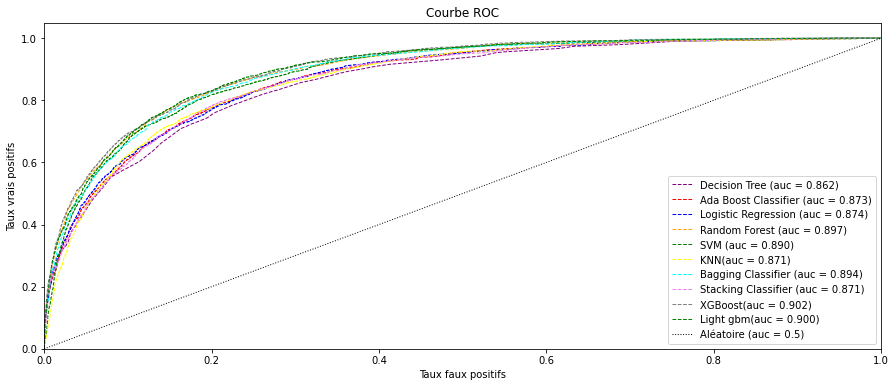

In [18]:
#Affichage des courbes ROC
plt.figure(figsize=(15,6))

plt.plot(fpr_dt, tpr_dt, color='purple',  linestyle='--', lw=1, label='Decision Tree (auc = %0.3f)' % roc_auc_dt)
plt.plot(fpr_ada, tpr_ada, color='red',  linestyle='--', lw=1, label='Ada Boost Classifier (auc = %0.3f)' % roc_auc_ada)
#plt.plot(fpr_IsoForest , tpr_IsoForest , color='gray',  linestyle='--', lw=1, label='Isolation Forest (auc = %0.2f)' % roc_auc_IsoForest)
plt.plot(fpr_RegLog, tpr_RegLog, color='blue',  linestyle='--', lw=1, label='Logistic Regression (auc = %0.3f)' % roc_auc_RegLog)
plt.plot(fpr_rf, tpr_rf, color='orange',  linestyle='--', lw=1, label='Random Forest (auc = %0.3f)' % roc_auc_rf)
plt.plot(fpr_svm, tpr_svm, color='green',  linestyle='--', lw=1, label='SVM (auc = %0.3f)' % roc_auc_svm)
plt.plot(fpr_knn, tpr_knn, color='yellow',  linestyle='--', lw=1, label='KNN(auc = %0.3f)' % roc_auc_knn)

plt.plot(fpr_bc, tpr_bc, color='cyan', linestyle='--', lw=1, label='Bagging Classifier (auc = %0.3f)' % roc_auc_bc)
plt.plot(fpr_sc, tpr_sc, color='violet', linestyle='--', lw=1, label='Stacking Classifier (auc = %0.3f)' % roc_auc_sc)
plt.plot(fpr_xgb, tpr_xgb, color='gray', linestyle='--', lw=1, label='XGBoost(auc = %0.3f)' % roc_auc_xgb)
plt.plot(fpr_l_gbm_J1, tpr_l_gbm_J1, color='green',  linestyle='--', lw=1, label='Light gbm(auc = %0.3f)' % roc_l_gbm_J1)

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle=':', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right");

<AxesSubplot:xlabel='threshold'>

Text(0.5, 1.0, 'Decision Tree')

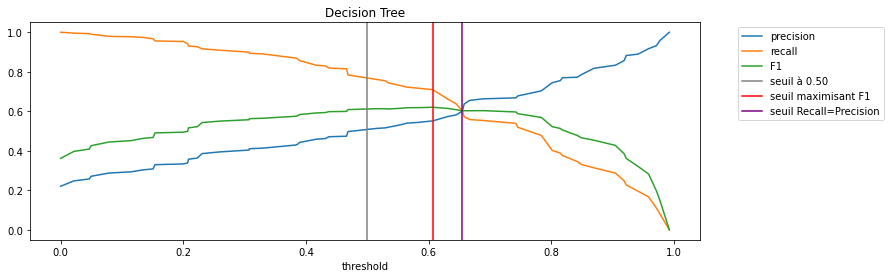

<AxesSubplot:xlabel='threshold'>

Text(0.5, 1.0, 'AdaBoost Classifier')

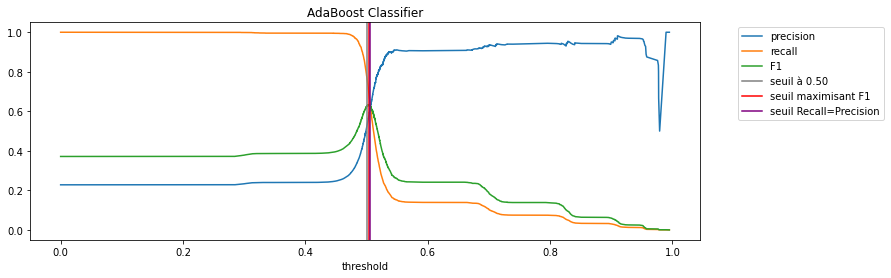

<AxesSubplot:xlabel='threshold'>

Text(0.5, 1.0, 'Regression logistique')

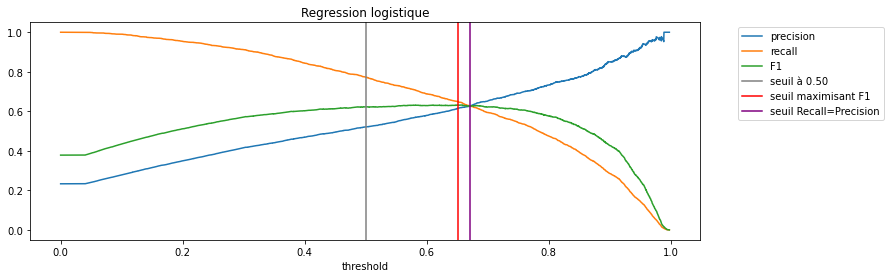

<AxesSubplot:xlabel='threshold'>

Text(0.5, 1.0, 'SVM')

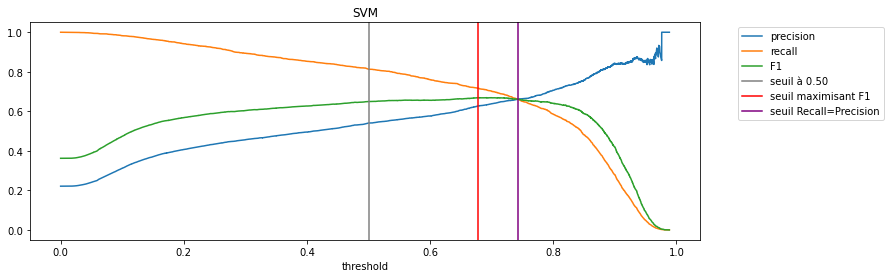

<AxesSubplot:xlabel='threshold'>

Text(0.5, 1.0, 'KNN')

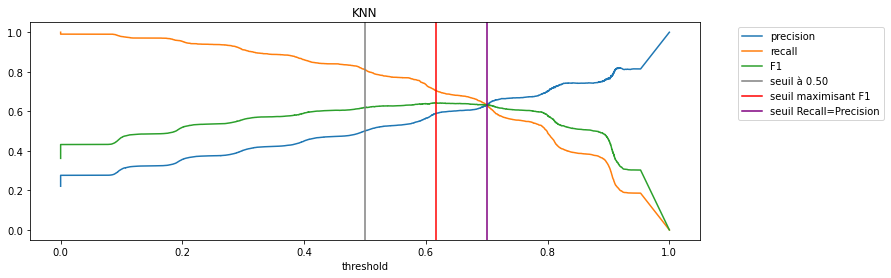

<AxesSubplot:xlabel='threshold'>

Text(0.5, 1.0, 'RF')

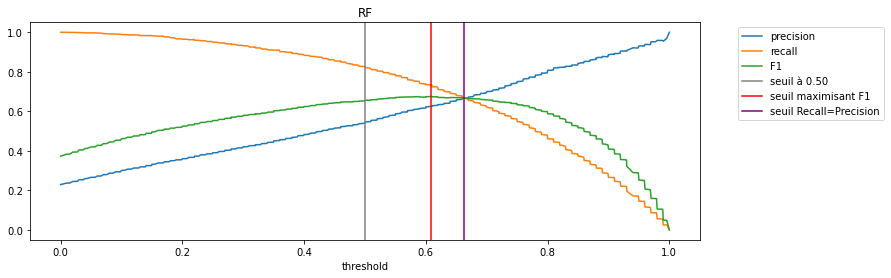

<AxesSubplot:xlabel='threshold'>

Text(0.5, 1.0, 'XGBoost')

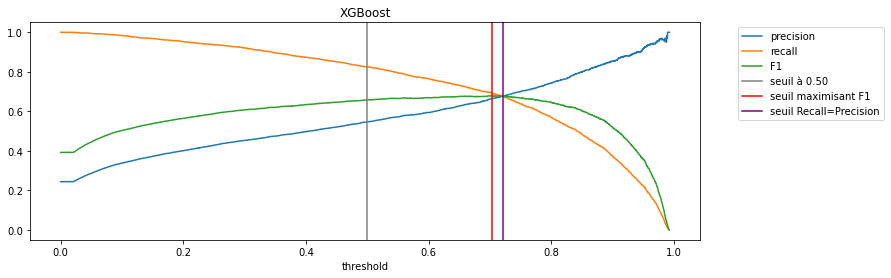

<AxesSubplot:xlabel='threshold'>

Text(0.5, 1.0, 'Light GBM')

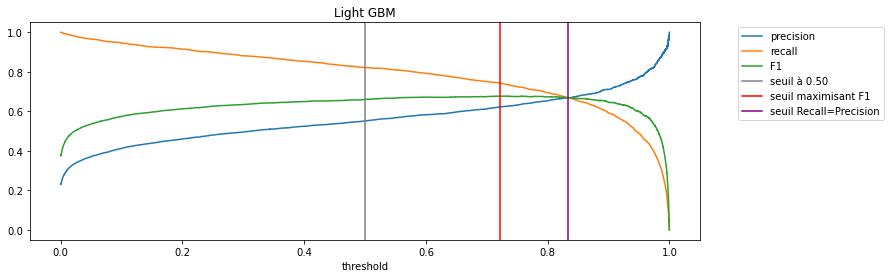

<AxesSubplot:xlabel='threshold'>

Text(0.5, 1.0, 'Bagging')

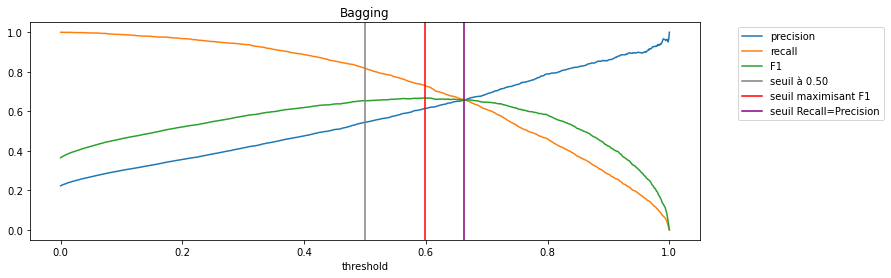

In [19]:
#Liste_Prob = [probs_dt[:,1],probs_ada[:,1],probs_RegLog[:,1],probs_knn[:,1],probs_rf[:,1],probs_xgbc[:,1],probs_l_gbm_J1[:, 1],probs_bc[:, 1],probs_sc[:,1]]
Nom_Modele = [dt_clf_ru,ac_ru,LogRef_ru,svm_ru,knn_ru,rf_ru,xgbc_ru,lgbm_ru,bc_ru,sclf]
BaseTest   = [X_test,X_test,X_test_sc,X_test_sc,X_test_sc,X_test,X_test,X_test,X_test,X_test_sc]
Lib_Modele = ["Decision Tree","AdaBoost Classifier","Regression logistique","SVM","KNN","RF","XGBoost","Light GBM","Bagging","Stacking"]

Sortie = pd.DataFrame()

for i in [0,1,2,3,4,5,6,7,8]:
    probs = Nom_Modele[i].predict_proba(BaseTest[i])
    precision, recall, thresholds = precision_recall_curve(y_test, probs[:,1], pos_label=1)
    dfpr = pd.DataFrame(dict(precision=precision, recall=recall, threshold=[0] + list(thresholds)))
    dfpr['F1']= 2 * (dfpr.precision * dfpr.recall) / (dfpr.precision + dfpr.recall)

    dfrpr_maxF1 = dfpr[dfpr.F1 == dfpr.F1.max()].reset_index()
    Seuil = dfrpr_maxF1["threshold"].values[0]

    dfpr["Diff_Recall_Precision"] = np.abs(dfpr["recall"]-dfpr["precision"])
    dfrpr_MinDiff = dfpr[dfpr.Diff_Recall_Precision == dfpr.Diff_Recall_Precision.min()].reset_index()
    Seuil1 = dfrpr_MinDiff["threshold"].values[0]

    dfpr.plot(x="threshold", y=['precision', 'recall', 'F1'], figsize=(12, 4));
    plt.axvline(x=0.50,color="gray",label="seuil à 0.50");
    plt.axvline(x=Seuil,color="red",label="seuil maximisant F1");
    plt.axvline(x=Seuil1,color="purple",label="seuil Recall=Precision");
    plt.title(Lib_Modele[i]);
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');
    plt.show();
    
    y_pred = np.where(probs[:,1] >= 0.50, 1, 0)    
    y_pred_best = np.where( probs[:,1] >= Seuil, 1, 0)
    y_pred_best1 = np.where( probs[:,1] >= Seuil1, 1, 0)
    
    Seuil050 = precision_recall_fscore_support(y_test,y_pred,pos_label=1,average="binary")
    SeuilF1 = precision_recall_fscore_support(y_test,y_pred_best,pos_label=1,average="binary")
    SeuilRecPrec = precision_recall_fscore_support(y_test,y_pred_best1,pos_label=1,average="binary")

    sample_data=[("1 - Seuil 0.50",0.50,Seuil050[0],Seuil050[1],Seuil050[2]),
                 ("2 - Seuil pour Maximiser F1",Seuil,SeuilF1[0],SeuilF1[1],SeuilF1[2]),
                 ("3 - Seuil pour Recall = Precision",Seuil1, SeuilRecPrec[0],SeuilRecPrec[1],SeuilRecPrec[2])]

    df = pd.DataFrame(sample_data, columns=['Choix','threshold','precision', 'recall','F1_score'])
    df["Modele"] = Lib_Modele[i]
    df["pos_label"] = "1"
    Sortie = pd.concat([Sortie, df])

In [53]:
Sortie = Sortie.sort_values(by=['Choix','F1_score'])
Sortie

,Choix,threshold,precision,recall,F1_score,Modele,pos_label
0,1 - Seuil 0.50,0.500000,0.497462,0.7840,0.608696,Decision Tree,1
0,1 - Seuil 0.50,0.500000,0.499753,0.8100,0.618132,KNN,1
0,1 - Seuil 0.50,0.500000,0.520559,0.7748,0.622729,Regression logistique,1
0,1 - Seuil 0.50,0.500000,0.518165,0.7816,0.623186,AdaBoost Classifier,1
0,1 - Seuil 0.50,0.500000,0.534902,0.8184,0.646957,SVM,1
0,1 - Seuil 0.50,0.500000,0.539405,0.8268,0.652874,RF,1
0,1 - Seuil 0.50,0.500000,0.543646,0.8196,0.653693,Bagging,1
0,1 - Seuil 0.50,0.500000,0.546780,0.8252,0.657740,XGBoost,1
0,1 - Seuil 0.50,0.500000,0.551854,0.8216,0.660238,Light GBM,1
1,2 - Seuil pour Maximiser F1,0.606667,0.544019,0.7168,0.618571,Decision Tree,1


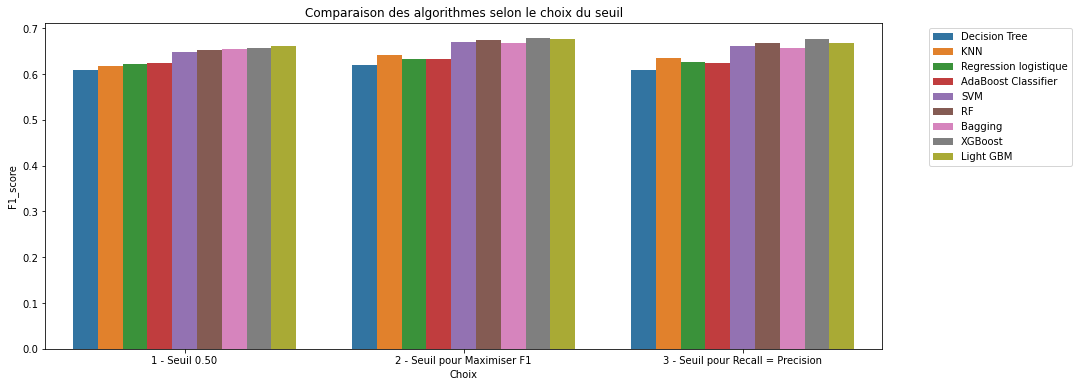

In [61]:
plt.figure(figsize=(15,6))
sns.barplot(x="Choix", y="F1_score", hue="Modele", data=Sortie)
plt.title('Comparaison des algorithmes selon le choix du seuil')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

<hr>
<h1>Conclusion</h1>
<hr>

La comparaison des algorithmes sur la courbe de ROC nous montre une liste d'algorithmes plus performants que les autres à savoir :
- la random forest
- le bagging
- la xgboost
- la light GBM
<br>

Les comparaisons sur le F1_score en choisissant les seuils de probabilités (0.50,F1_max,recall=precision) vont nous conduite à préférer la XGBOOST qui est légèrement plus performante que la lightGBM sur le seuil "recall=precision".

